# LIBRARIES

In [1]:
import networkx as nx
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score,recall_score
import matplotlib.pyplot as plt
from typing import Optional,Tuple

import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn
from torch_geometric.data import Data
import torch_geometric.utils as pyg_utils
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# DATASET

In [2]:
transform = T.Compose([
    T.NormalizeFeatures(),
    T.to_device.ToDevice(device),
    T.RandomLinkSplit(num_val=0.05, num_test=0.25, is_undirected=True,
                      split_labels=True, add_negative_train_samples=False),
])
dataset = Planetoid(root='/train/Cora', name='Cora',transform=transform)
train_data, val_data, test_data = dataset[0]
{
    'graph number': len(dataset),
    'num_classes': dataset.num_classes,
    'num_node_features': dataset.num_node_features,
    'graph' : dataset[0],
}

{'graph number': 1,
 'num_classes': 7,
 'num_node_features': 1433,
 'graph': (Data(x=[2708, 1433], edge_index=[2, 7392], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], pos_edge_label=[3696], pos_edge_label_index=[2, 3696]),
  Data(x=[2708, 1433], edge_index=[2, 7392], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], pos_edge_label=[263], pos_edge_label_index=[2, 263], neg_edge_label=[263], neg_edge_label_index=[2, 263]),
  Data(x=[2708, 1433], edge_index=[2, 7918], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], pos_edge_label=[1319], pos_edge_label_index=[2, 1319], neg_edge_label=[1319], neg_edge_label_index=[2, 1319]))}

# MODEL

In [3]:
class GCN_Encoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN_Encoder, self).__init__()
        self.gcn_shared = pyg_nn.GCNConv(in_channels, hidden_channels)
        self.gcn_mu = pyg_nn.GCNConv(hidden_channels, out_channels)
        self.gcn_logvar = pyg_nn.GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.gcn_shared(x, edge_index))
        mu = self.gcn_mu(x, edge_index)
        logvar = self.gcn_logvar(x, edge_index)
        return mu, logvar
    
class GCN_Pre_Encoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN_Pre_Encoder, self).__init__()
        self.gcn_shared = pyg_nn.GCNConv(in_channels, hidden_channels)
        self.preprocess = nn.Sequential(
            nn.Linear(in_channels,2*in_channels),
            nn.ReLU(),
            nn.BatchNorm1d(2*in_channels),
            nn.Linear(2*in_channels,in_channels),
            nn.ReLU(),
            nn.BatchNorm1d(in_channels),
            )
        self.gcn_mu = pyg_nn.GCNConv(hidden_channels, out_channels)
        self.gcn_logvar = pyg_nn.GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.preprocess(x)
        x = F.relu(self.gcn_shared(x, edge_index))
        mu = self.gcn_mu(x, edge_index)
        logvar = self.gcn_logvar(x, edge_index)
        return mu, logvar

class GAT_Encoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels,head=1):
        super(GAT_Encoder, self).__init__()
        self.preprocess = nn.Sequential(
            nn.Linear(in_channels,2*in_channels),
            nn.ReLU(),
            nn.BatchNorm1d(2*in_channels),
            nn.Linear(2*in_channels,in_channels),
            nn.ReLU(),
            nn.BatchNorm1d(in_channels),
            )
        self.gcn_shared = pyg_nn.GATv2Conv(in_channels, hidden_channels,head=head)
        self.gcn_mu = pyg_nn.GATv2Conv(hidden_channels, out_channels,head=head)
        self.gcn_logvar = pyg_nn.GATv2Conv(hidden_channels, out_channels,head=head)
        

    def forward(self, x, edge_index):
        x = self.preprocess(x)
        x = F.relu(self.gcn_shared(x, edge_index))
        mu = self.gcn_mu(x, edge_index)
        logvar = self.gcn_logvar(x, edge_index)
        return mu, logvar

class VGAE_Node_Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(VGAE_Node_Decoder, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent_dim,hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.ReLU(),
        )

    def forward(self, z):
        x = self.fc(z)
        return x

in_channels = train_data.num_node_features
hidden_channels = in_channels * 2
latent_dim = 32

In [4]:
@torch.no_grad()
def test(model,data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    auc,ap = model.test(z, data.pos_edge_label_index, data.neg_edge_label_index)
    loss = model.recon_loss(z, data.pos_edge_label_index, data.neg_edge_label_index)
    loss = loss + (1 / train_data.num_nodes) * model.kl_loss()
    return loss.item(),auc,ap

# Training loop
def update(model,data,optimizer):
    model.train()
    z = model.encode(data.x, data.edge_index)
    # note that the graph is undirected, then data.pas_edge_label_index is half of original edge index
    loss = model.recon_loss(z, data.edge_index)
    loss = loss + (1 / data.num_nodes) * model.kl_loss()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()

def train(model,optimizer,hist,n):
    for epoch in range(n):
        loss = update(model,train_data,optimizer)
        hist['train']['loss'].append(loss)
        
        loss,auc,ap = test(model,test_data)
        hist['test']['loss'].append(loss)
        hist['test']['auc'].append(auc)
        hist['test']['ap'].append(ap)
        if (epoch+1) % 10 == 0 :
            from IPython.display import clear_output
            clear_output()
            print(f"average precision {ap:.4f}")
            plot_loss(hist)

    hist['test']['ap'][-1]

def init_hist():
    hist = {'train':{},'test':{}}
    metrics = "loss auc ap"
    for mode in "train test".split():
        for m in metrics.split():
            hist[mode][m]=[]
    return hist

def plot_loss(hist):
    fig,axs = plt.subplots(1,3,figsize=(12,4))
    epoch = len(hist['train']['loss'])
    fig.suptitle(f'epoch - {epoch}')
    for ax,m in zip(axs.flatten(),hist['train'].keys()):
        ax.set_title(m)
        ax.plot(hist['train'][m],label='train')
        ax.plot(hist['test'][m],label='test')
        ax.legend()
    
    plt.show()

average precision 0.8723


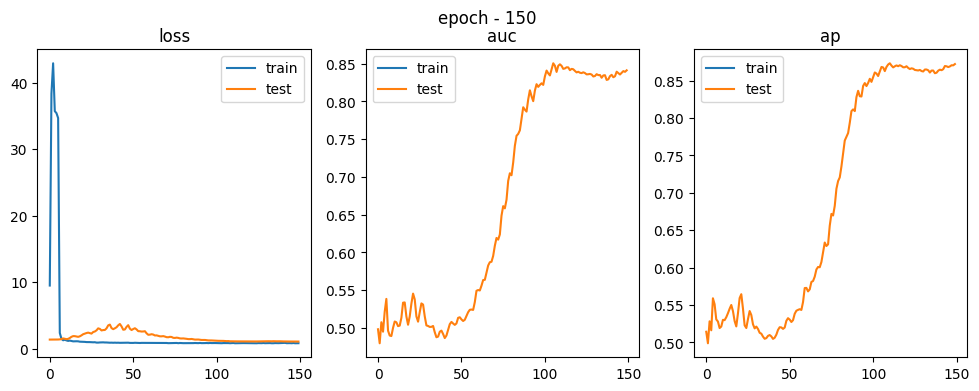

0.8723120244589601

In [5]:
model = pyg_nn.VGAE(GAT_Encoder(in_channels,hidden_channels,latent_dim))
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)
hist = init_hist()
train(model,optimizer,hist,150)
hist['test']['ap'][-1]

average precision 0.8980


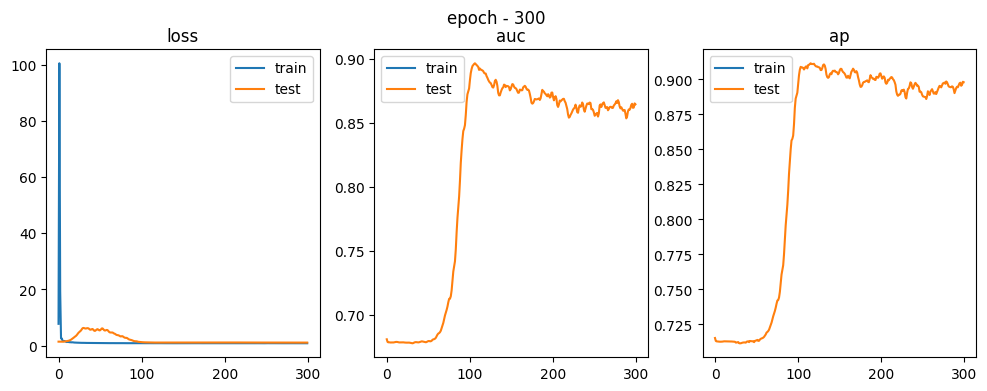

0.8979937238380594

In [6]:
model = pyg_nn.VGAE(GCN_Pre_Encoder(in_channels,hidden_channels,latent_dim))
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)

hist = init_hist()

train(model,optimizer,hist,300)
hist['test']['ap'][-1]

average precision 0.9196


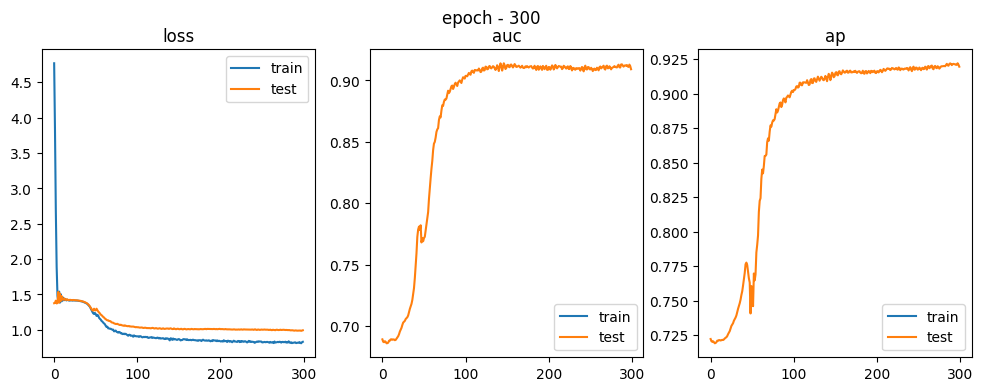

0.919610059088318

In [7]:
model = pyg_nn.VGAE(GCN_Encoder(in_channels,hidden_channels,latent_dim))
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(),lr = 0.005)
hist = init_hist()
train(model,optimizer,hist,300)
hist['test']['ap'][-1]

# Observation

1. precision = true positive / all predicted positive
2. recall =  true positive / all positive

In words, precision tells us how many are true positive among all predicted positive whereas recall how many positive is captured among all positive. High precision but low recall implies that the model is very conservative such that it will make sure all predictions are right but not capturing all; underestimating link presence.

In [8]:
data = val_data
z = model.encode(data.x, data.edge_index)
adj = model.decoder.forward_all(z) >= 0.95
edge_index = pyg_utils.dense_to_sparse(adj)[0]
(edge_index.shape, 
 val_data.edge_index.shape, 
 edge_index.shape[1] / val_data.edge_index.shape[1])

(torch.Size([2, 37749]), torch.Size([2, 7392]), 5.106737012987013)

In [9]:
def fn(model,data,threshold=None):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    adj = model.decoder.forward_all(z)
    adj = adj.long() if threshold is None else adj >= threshold
    edge_index = pyg_utils.dense_to_sparse(adj)[0]
    
    fn = lambda t : t.flatten().cpu().long()
    pred,target = fn(adj), fn(pyg_utils.to_dense_adj(val_data.edge_index))
    
    cm = confusion_matrix(target,pred)
    
    tn = cm[0, 0]
    fp = cm[0, 1]
    fn = cm[1, 0]
    tp = cm[1, 1]
    
    precision = tp / (tp+fp)
    recall = tp / (tp+fn)
    acc = (tn+tp) / sum([tn,fn, fp, tp])
    f1 = (precision * recall)/(precision + recall)
    
    return {
        "ideal_cm":confusion_matrix(target,target),
        "cm": cm,
        "inv_size_ratio": data.edge_index.shape[1]/edge_index.shape[1],
        "precision": precision,
        # "precision_score":precision_score(target,pred),
        "recall": recall,
        # "recall_score": recall_score(target,pred),
        "acc" : acc,
        "f1": f1
    }
'''
[[tn,fp], # n
 [fn,tp]] # p
'''
fn(model,train_data,0.95)

{'ideal_cm': array([[7325872,       0],
        [      0,    7392]], dtype=int64),
 'cm': array([[7293465,   32407],
        [   2050,    5342]], dtype=int64),
 'inv_size_ratio': 0.19581975681475006,
 'precision': 0.14151368248165513,
 'recall': 0.7226731601731602,
 'acc': 0.9953012737574973,
 'f1': 0.11834031146850976}

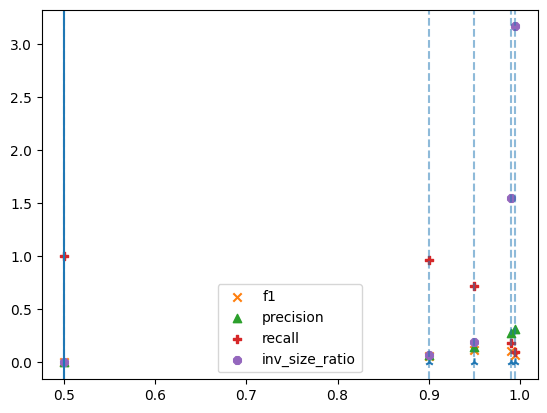

In [10]:
x = [0.5,0.9,0.95,0.99,0.995]
y = []
precision_hist = []
recall_hist = []
size_hist = []
for t in x:
    res = fn(model,train_data,t)
    precision_hist.append(res['precision'])
    recall_hist.append(res['recall'])
    size_hist.append(res['inv_size_ratio'])
    y.append(res['f1'])

plt.scatter(x,[0 for _ in x],marker='2')
plt.axvline(x[0])
[plt.axvline(1 if i is None else i,alpha=0.5,ls='--') for i in x]
plt.scatter(x,y,label='f1',marker='x')
plt.scatter(x,precision_hist,label='precision',marker='^')
plt.scatter(x,recall_hist,label='recall',marker='P')
plt.scatter(x,size_hist,label='inv_size_ratio',marker='8')
plt.legend()

In [11]:
THRESHOLD = 0.95

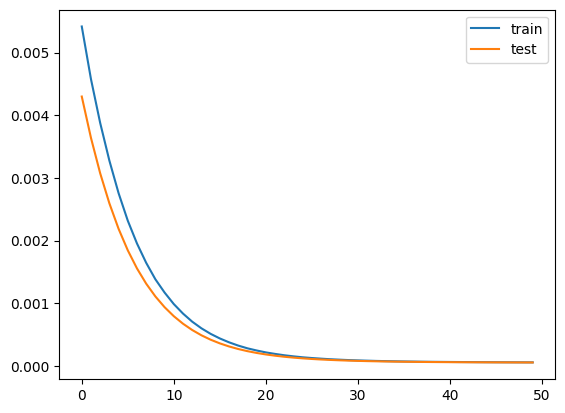

In [12]:
class VGAE_Node_Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(VGAE_Node_Decoder, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent_dim,hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.ReLU(),
        )

    def forward(self, z):
        x = self.fc(z)
        return x

def test(encoder,decoder,data):
    encoder.eval()
    decoder.eval()
    z= encoder.encode(data.x, data.edge_index)
    x = decoder(z)
    loss = F.mse_loss(x,data.x)
    return loss.item()

# Training loop
def train(encoder,decoder,data,optimizer):
    encoder.train()
    decoder.train()
    z = encoder.encode(data.x, data.edge_index)
    x = decoder(z)
    loss = F.mse_loss(x,data.x)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()

node_model = VGAE_Node_Decoder(latent_dim,latent_dim*3,train_data.num_node_features)
node_model = node_model.to(device)
optimizer = torch.optim.Adam(node_model.parameters(),lr=0.001)
train_hist,test_hist = [],[]

for i in range(50):
    loss = train(model,node_model,train_data,optimizer)
    train_hist.append(loss)
    loss = test(model,node_model,test_data)
    test_hist.append(loss)

plt.plot(train_hist,label='train')
plt.plot(test_hist,label='test')
plt.legend()

In [13]:
def reconstruct_data(gae_model,decoder,data,threshold=None):
    z = gae_model.encode(data.x, data.edge_index)
    x = decoder(z).detach()
    adj = gae_model.decoder.forward_all(z).detach()
    # adj = adj > threshold
    adj = adj.long() if threshold is None else adj > threshold
    edge_index = pyg_utils.dense_to_sparse(adj)[0]
    recon_data = Data(x=x,edge_index=edge_index,
                      y=data.y,
                      train_mask = data.train_mask,
                      test_mask = data.test_mask,
                      val_mask = data.val_mask)
    return recon_data.to(device)

In [14]:
dataset = Planetoid(root='/data/Cora', name='Cora')
data = dataset[0].to(device)

In [15]:
class GCN(nn.Module):
    def __init__(self,in_channels=dataset.num_node_features, 
                 hidden_channels = 16, out_channels = dataset.num_classes,seed=42):
        super().__init__()
        torch.manual_seed(seed)
        self.conv1 = pyg_nn.GCNConv(in_channels, hidden_channels)
        self.conv2 = pyg_nn.GCNConv(hidden_channels, out_channels)
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x,edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.log_softmax(x, dim=1)
        return x

def plot_loss(hist):
    plt.title(f'epoch - {len(hist["train"])}')
    plt.plot(hist['train'],label='train')
    plt.plot(hist['test'],label='test')
    plt.legend()
    plt.show()

def test(model,data):
    out = model(data)
    pred = model(data).argmax(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
    acc = int(correct) / int(data.test_mask.sum())
    return acc
    
def train(model,dataset,optimizer, hist, n = 100):
    for epoch in range(n):
        train_losses = []
        test_losses = []
        for data in dataset:
            model.train()
            out = model(data)
            loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
            
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        
        
            model.eval()
            loss = F.nll_loss(out[data.test_mask], data.y[data.test_mask])
            test_losses.append(loss.item())
        
        mean = lambda xs : torch.tensor(xs).mean()   
        hist['train'].append(mean(train_losses))
        hist['test'].append(mean(test_losses))
    
    plot_loss(hist)
    pred = model(data).argmax(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
    acc = int(correct) / int(data.test_mask.sum())
    print(f'Accuracy: {acc:.4f}')

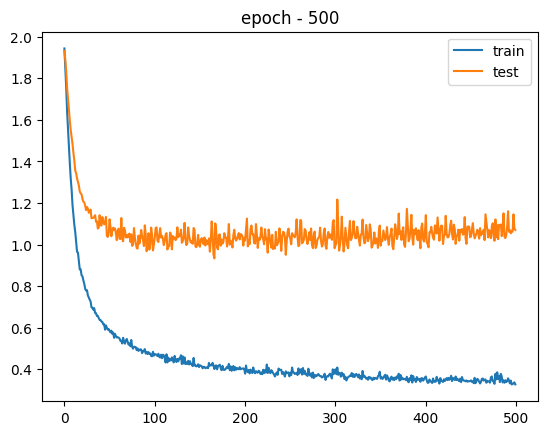

Accuracy: 0.7080


(0.708, 0.742)

In [16]:
classifier_model = GCN().to(device)
hist = {'train':[],'test':[]}
optimizer = torch.optim.Adam(classifier_model.parameters(), lr=0.01, weight_decay=5e-4)
recon_data = reconstruct_data(model,node_model,data,THRESHOLD)
train(classifier_model,[data,recon_data], optimizer, hist, n=500)
x1 = test(classifier_model,recon_data)
x2 = test(classifier_model,data)
x1,x2

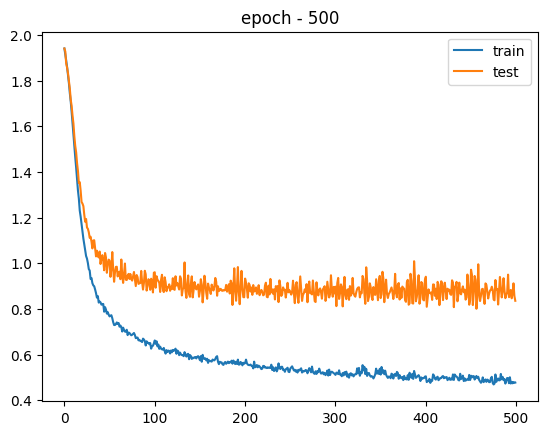

Accuracy: 0.7210


(0.721, 0.135)

In [17]:
classifier_model = GCN().to(device)
optimizer = torch.optim.Adam(classifier_model.parameters(), lr=0.01, weight_decay=5e-4)
hist = {'train':[],'test':[]}
recon_data = reconstruct_data(model,node_model,data)
train(classifier_model,[recon_data,recon_data], optimizer,hist,n=500)
x1 = test(classifier_model,recon_data)
x2 = test(classifier_model,data)
x1,x2

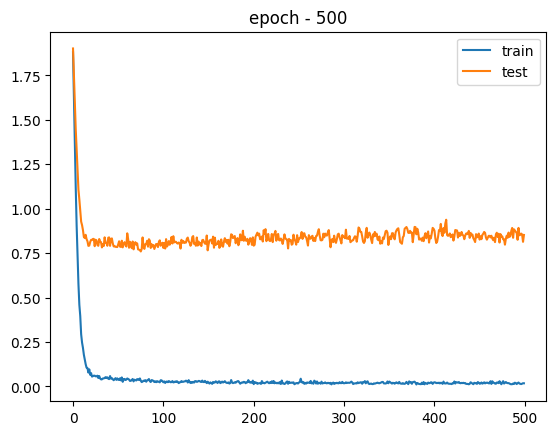

Accuracy: 0.8130


(0.319, 0.813)

In [18]:
classifier_model = GCN().to(device)
optimizer = torch.optim.Adam(classifier_model.parameters(), lr=0.01, weight_decay=5e-4)
hist = {'train':[],'test':[]}
train(classifier_model,[data,data], optimizer,hist,n=500)

x1 = test(classifier_model,reconstruct_data(model,node_model,data))
x2 = test(classifier_model,data)
x1,x2